Independent variable
  - Rest length of the string $L$

Control variables
  - Mass of the lock: $200\mathrm{g}$
  - Center of mass of the lock from the top: $5\mathrm{cm}$
  - Air resistance of the lock $-kv^2$
  - String constraint $C(\Delta L) = Le^{\Delta L/L} - \Delta L$ for $\Delta L > 0$
    - String force $F_s(\Delta L) = -k_s C'(\Delta L)C(\Delta L)$
    - String damping $F_d(\Delta x) = -k_d C'(\Delta L) C'(\Delta L)\cdot v$
  - Movable frame constraint $C(r) = |r|^2$
    - Moveable frame force $F_s(r) = -k_s C'(r)C(r)$
    - Moveable frame damping $F_d(r) = -k_d C'(r) C'(r)\cdot v$



Adjust control variables to fit experimental data.

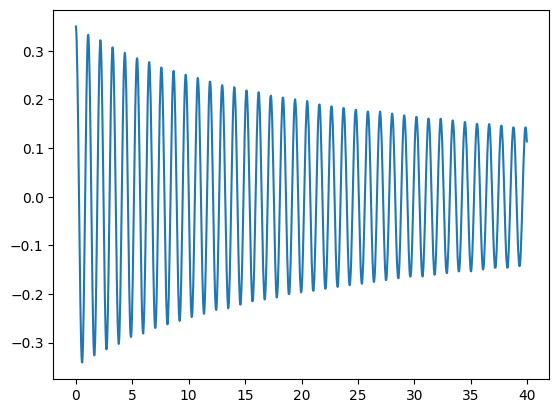

In [1]:
from math import *
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt

g = 9.81
M = 0.2  # mass of the lock
Lm = 0.05  # center of mass of the lock
L = 0.20

def func(u, t):
    mx, my, mz, fdx, fdy, vx, vy, vz, fvx, fvy = u
    x = np.array([mx, my, mz])
    fx = np.array([fdx, fdy, 0])
    v = np.array([vx, vy, vz])
    fv = np.array([fvx, fvy, 0])
    a = np.array([0.0, 0.0, -g])
    fa = np.array([0.0, 0.0, 0.0])

    # air resistance
    a -= 0.004 * np.linalg.norm(v) * v / M

    # string constraint
    L1 = np.linalg.norm(x-fx)
    dL = L1-Lm - L
    if dL > 0:
        ks, kd = 300.0, 4000.0
        Cs = L * exp(dL/L) - dL
        dCs = (exp(dL) - 1.0) * (x-fx)/L1
        a -= ks * Cs * dCs / M
        a -= kd * dCs * np.dot(dCs, v) / M
        fa += ks * Cs * dCs
        fa += kd * dCs * np.dot(dCs, fv)

    # frame constraint
    r = np.linalg.norm(fx)
    if r != 0.0:
        # ks, kd = 2000000.0, 8000.0
        # Cs = r*r
        # dCs = 2*r * fx/r
        # fa -= ks * Cs * dCs
        # fa -= kd * dCs * np.dot(dCs, fv)
        k = 1.2
        ks, kd = 2000.0**k, 400.0
        Cs = r**k
        dCs = k*r**(k-1) * fx/r
        fa -= ks * Cs * dCs
        c = np.linalg.norm(fv) / 0.005
        fa -= kd * dCs * c * np.dot(dCs, fv)

    return [vx, vy, vz, fvx, fvy, *a, *fa[:2]]


l0 = 1.03*L+Lm
a0 = 20 * pi/180
ts = np.arange(30*40) / 30
xs = scipy.integrate.odeint(func,
    [l0*sin(a0), 0, -l0*cos(a0), 0, 0, 0, 0, 0, 0, 0], ts)
xs = np.round(xs, 3)

#plt.plot(xs[:, 0], xs[:, 2])
#plt.plot(ts, np.hypot(xs[:, 0], xs[:, 2]))
plt.plot(ts, np.arctan2(xs[:, 0], -xs[:, 2]))
plt.show()

Analyze data

[ 0.32182113 43.69762381  1.0770546  -0.18270217] [1.12373485e-03 3.79385353e-01 3.73605123e-05 3.57315340e-03]
Period: 1.07705 ± 0.00004
Q factor: 254.9 ± 2.2


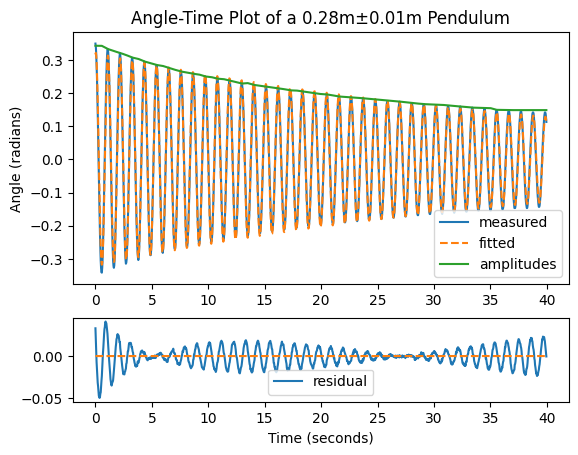

In [21]:
def damped_exp(t, a0, tau):
    if tau < 0:
        return float('nan')
    return a0 * np.exp(-t/tau)

def damped_rat(t, a0, tau):
    if tau < 0:
        return float('nan')
    return a0 / (1.0 + t/tau)

def fit_amplitude(model, t, amp, amp_error):
    popt, popv = scipy.optimize.curve_fit(
        model, t, amp,
        sigma=amp_error*np.ones(len(amp)),
        p0=(0.4, 60.))
    # return popt, popv.diagonal()**0.5
    return popt, np.diagonal(popv)**0.5

def damped_harmonic(t, a0, tau, period, phase):
    a = damped_exp(t, a0, tau)
    return a * np.cos(2.*np.pi*t/period + phase)

def fit_data(t, a, a_error, a0_guess=0.4, tau_guess=60.):
    init_guess = (a0_guess, tau_guess, 2.0*sqrt(L), 0.0)
    init_guess = scipy.optimize.curve_fit(
        damped_harmonic, t[:100], a[:100], p0=init_guess)[0]
    init_guess = scipy.optimize.curve_fit(
        damped_harmonic, t[:300], a[:300], p0=init_guess)[0]
    popt, popv = scipy.optimize.curve_fit(
        damped_harmonic, t, a,
        p0=init_guess, sigma=a_error*np.ones(len(a)))
    return popt, popv.diagonal()**0.5

def get_amplitudes(t, a):
    t_amp = []
    a_amp = []
    for i in range(1, len(a)-1):
        if (a[i]-a[i-1]) * (a[i]-a[i+1]) <= 0:
            continue
        # if a[i] < 0:
        #     continue
        if False:  # naive approach
            ti, ai = t[i], a[i]
        else:  # quadratic fit - doesn't improve much?
            coes = np.polyfit(t[i-1:i+2], a[i-1:i+2], 2)
            ti = -coes[1]/(2*coes[0])
            ai = coes[2]+ti*(coes[1]+ti*coes[0])
        if len(a_amp) == 0 or abs(ai / a_amp[-1]) > 0.8:
            t_amp.append(ti)
            a_amp.append(abs(ai))
    return np.interp(t, t_amp, a_amp)

def plot_angle_time_graph(l, l_error, t, a, amps, params):
    a_pred = damped_harmonic(t, *params)
    residual = a - a_pred

    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

    ax1.set_title("Angle-Time Plot of a {:.2f}m±{:.2f}m Pendulum".format(l, l_error))
    ax2.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Angle (radians)")

    ax1.plot(t, a, '-')
    ax1.plot(t, a_pred, '--')
    ax1.plot(t, amps, '-')
    ax1.legend(['measured', 'fitted', 'amplitudes'])

    ax2.plot(t, residual)
    ax2.legend(["residual"])
    ax2.plot(t, np.zeros(len(t)), '--')
    plt.show()

l = np.hypot(xs[:, 0], xs[:, 2])
l = np.mean(l)
l_error = sqrt(np.var(l) + 0.01**2)
a = np.arctan2(xs[:, 0], -xs[:, 2])
a -= np.mean(a)
a_error = 0.01 * np.maximum(abs(xs[:, 2]), abs(xs[:, 0])) / (xs[:, 0]**2 + xs[:, 2]**2)

params, perror = fit_data(ts, a, a_error)
print(params, perror)
print("Period: {:.5f} ± {:.5f}".format(params[2], perror[2]))

q = 2.0*np.pi * params[1] / params[2]
q_e = 2.0*np.pi * max(abs(perror[1] / params[2]), abs(perror[2] * params[1] / params[2]**2))
print("Q factor: {:.1f} ± {:.1f}".format(q, q_e))

amps = get_amplitudes(ts, a)
plot_angle_time_graph(l, l_error, ts, a, amps, params)

Run batch with uncertainties.

In [22]:
import random
random.seed(0)

def trig_distribution(center, spread):
    """Distribution of human error"""
    return center + spread * (random.random() + random.random() - 1)

def random_sphere(spread):
    u = 2.0*pi * random.random()
    v = 2.0*random.random()-1.0
    r = sqrt(1-v*v)
    n = np.array([r*cos(u), r*sin(u), v])
    return trig_distribution(0.0, spread) * n

def batch_pass(l0):
    global L, g
    L = l0

    g = trig_distribution(9.81, 0.05)  # fake
    l0 = trig_distribution(1.03, 0.01) * L + Lm
    a0 = trig_distribution(30, 5) * pi/180
    ts = np.arange(40*30) / 30
    x0 = [l0*sin(a0), 0, -l0*cos(a0)] + random_sphere(0.005*l0)
    v0 = random_sphere(0.005*l0)
    xs = scipy.integrate.odeint(func, [*x0, 0, 0, *v0, 0, 0], ts)
    time_clip = int(abs(trig_distribution(0, 2.0*30)))
    ts, xs = ts[time_clip:], xs[time_clip:]
    xs = np.round(xs, 3)

    l = np.hypot(xs[:, 0], xs[:, 2])
    l_error = sqrt(np.var(l) + 0.01**2)
    l = round(np.mean(l), 2)
    print("Length: {:.2f}m±{:.2f}m".format(l, l_error))

    a = np.arctan2(xs[:, 0], -xs[:, 2])
    a -= np.mean(a)
    a_error = 0.01 * np.maximum(abs(xs[:, 2]), abs(xs[:, 0])) / (xs[:, 0]**2 + xs[:, 2]**2)

    params, perror = fit_data(ts, a, a_error)
    T, T_e = params[2], perror[2]
    print(params, perror)
    print("Period: {:.5f}s±{:.5f}s".format(T, T_e))

    def dydxerr(dx, dxerr, dy, dyerr):
        return max(abs(dyerr/dx), abs(dxerr*dy/dx**2))

    def calc_q(t1, t2):
        a1, a2 = np.interp(t1, ts, amps), np.interp(t2, ts, amps)
        aerr = np.sqrt(0.5)*np.amax(a_error)  # may be inaccurate
        ac, acerr = a1 / a2, dydxerr(a2, aerr, a1, aerr)
        lc, lcerr = np.log(ac), abs(acerr / ac)
        n, nerr = (t2-t1)/T, dydxerr(T, T_e, t2-t1, 0.0)
        q, qerr = n/lc, dydxerr(lc, lcerr, n, nerr)
        return 2.0*np.pi*q, 2.0*np.pi*qerr

    amps = get_amplitudes(ts, a)
    params_exp, perror_exp = fit_amplitude(damped_exp, ts, amps, a_error)
    q_exp = 2.0*np.pi * params_exp[1]/T
    qe_exp = 2.0*np.pi * dydxerr(T, T_e, params_exp[1], perror_exp[1])
    params_rat, perror_rat = fit_amplitude(damped_rat, ts, amps, a_error)
    q_rat = 2.0*np.pi * params_rat[1]/T
    qe_rat = 2.0*np.pi * dydxerr(T, T_e, params_rat[1], perror_rat[1])
    q01, qe01 = calc_q(0.0, 10.0)
    q12, qe12 = calc_q(10.0, 20.0)
    q24, qe24 = calc_q(20.0, 40.0)
    print("Q factor (exp, rat, q01, q12, q24): "
        "{:.1f}±{:.1f}, {:.1f}±{:.1f}, {:.1f}±{:.1f}, {:.1f}±{:.1f}, {:.1f}±{:.1f}".format(
            q_exp, qe_exp, q_rat, qe_rat, q01, qe01, q12, qe12, q24, qe24))

    # plot_angle_time_graph(l, l_error, ts, a, amps, params)
    
    # plt.plot(ts, amps)
    # plt.plot(ts, damped_exp(ts, *params_exp), label="exp")
    # plt.plot(ts, damped_rat(ts, *params_rat), label="rat")
    # plt.legend()
    # return

    return {
        't': ts,
        'l': l,
        'l_error': l_error,
        'a': a,
        'a_error': a_error,
        'T': T,
        'T_error': T_e,
        'q': (q_exp, q_rat, q01, q12, q24),
        'q_error': (qe_exp, qe_rat, qe01, qe12, qe24)
    }

ls = []
les = []
Ts = []
Tes = []
qs = []
qes = []
for l0 in [0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2][:]:
    params = batch_pass(l0)
    ls.append(params['l'])
    les.append(params['l_error'])
    Ts.append(params['T'])
    Tes.append(params['T_error'])
    qs.append(params['q'])
    qes.append(params['q_error'])
qs, qes = np.array(qs), np.array(qes)


Length: 0.28m±0.01m
[ 0.44131233 32.46510112  1.07821458 -0.34726394] [3.08021335e-03 4.64689494e-01 8.23509560e-05 7.08738979e-03]
Period: 1.07821s±0.00008s
Q factor (exp, rat, q01, q12, q24): 191.4±1.3, 102.7±0.3, 120.7±20.5, 198.6±74.3, 319.7±138.6
Length: 0.33m±0.01m
[ 0.47206582 42.47469918  1.16121299 -0.38493863] [3.44452598e-03 7.51642365e-01 9.08671909e-05 7.52700030e-03]
Period: 1.16121s±0.00009s
Q factor (exp, rat, q01, q12, q24): 230.9±1.1, 141.7±0.3, 173.7±33.0, 225.5±70.6, 328.0±104.0
Length: 0.37m±0.01m
[ 0.51057299 57.33593469  1.24531895 -0.32115567] [3.32452630e-03 1.14035574e+00 8.90763252e-05 6.86304462e-03]
Period: 1.24532s±0.00009s
Q factor (exp, rat, q01, q12, q24): 292.7±0.8, 206.6±0.1, 249.9±54.6, 265.6±74.6, 377.4±98.4
Length: 0.42m±0.01m
[ 0.4607001  83.47463692  1.31806644 -0.20514355] [1.88486661e-03 1.39830297e+00 5.73399337e-05 4.28594057e-03]
Period: 1.31807s±0.00006s
Q factor (exp, rat, q01, q12, q24): 403.7±0.9, 316.3±0.7, 417.6±150.4, 361.2±128.3, 527

Period vs. Length

[a, k] = [2.03025208 0.49654983] [0.00231253 0.0020068 ]
LinregressResult(slope=0.4978856225004091, intercept=0.3078408568420592, rvalue=0.9998941672665246, pvalue=5.487859127528428e-16, stderr=0.00256120340395918, intercept_stderr=0.0008433916725347157)
r^2 = 0.9997883457336166


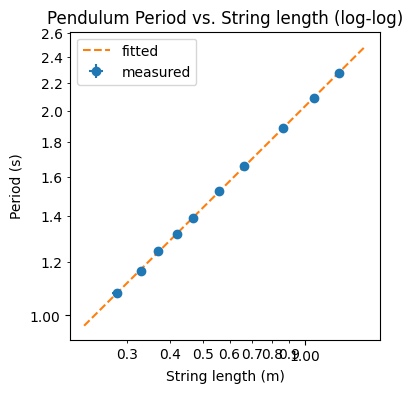

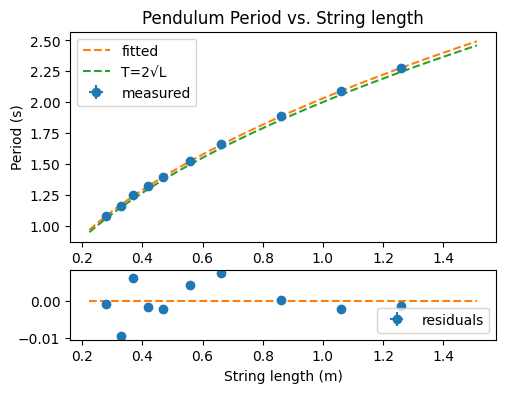

In [23]:
def power_fun(x, a, k):
    return a * x**k

params, popv = scipy.optimize.curve_fit(
    power_fun, ls, Ts,
    p0=(2, 0.5), sigma=Tes)
print("[a, k] =", params, popv.diagonal()**0.5)

xp = np.linspace(0.8*ls[0], 1.2*ls[-1], 100)
yp = power_fun(xp, *params)

## logarithmic scale plots

fig, (ax2) = plt.subplots(1, 1, figsize=(4, 4))

ax2.set_title("Pendulum Period vs. String length (log-log)")
ax2.set_xlabel("String length (m)")
ax2.set_ylabel("Period (s)")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.errorbar(ls, Ts, xerr=les, yerr=Tes, fmt="o", label="measured")
ax2.plot(xp, yp, "--", label="fitted")
ax2.legend()

from scipy.stats import linregress
linreg_params = linregress(np.log10(ls), np.log10(Ts))
print(linreg_params)
print("r^2 =", linreg_params.rvalue**2)

# https://splunktool.com/how-to-remove-scientific-notation-on-a-matplotlib-loglog-plot
import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter()
formatter.set_scientific(False)
ax2.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_minor_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_minor_formatter(formatter)

plt.show()

## Linear plot with residual

residual = Ts - power_fun(ls, *params)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(5.5, 4))

ax1.set_title("Pendulum Period vs. String length")
ax2.set_xlabel("String length (m)")
ax1.set_ylabel("Period (s)")

ax1.errorbar(ls, Ts, xerr=les, yerr=Tes, fmt="o", label="measured")
ax1.plot(xp, yp, "--", label="fitted")
ax1.plot(xp, 2*xp**0.5, "--", label="T=2√L")
ax1.legend()

ax2.errorbar(ls, residual, xerr=les, yerr=Tes, fmt="o", label="residuals")
ax2.plot(xp, yp-yp, "--")
ax2.legend()
plt.show()


Q factor vs. Length

[ 3.70468259e-03  8.36317828e-01  5.78580504e-07 -8.14867010e+00] [1.99169120e-04 1.55567990e-01 1.39984865e-06 2.34515256e+00]
[ 3.64690305e-03  8.99991948e-01  1.00044858e-05 -5.31766962e+00] [1.88226573e-04 2.18059688e-01 1.48070209e-05 1.26115869e+00]


C:\Users\harry\AppData\Local\Temp\ipykernel_15884\683133539.py:10: RuntimeWarning: invalid value encountered in log
  lambda x, a1, k1, a2, k2: np.log(fit_fun(x, a1, k1, a2, k2)),


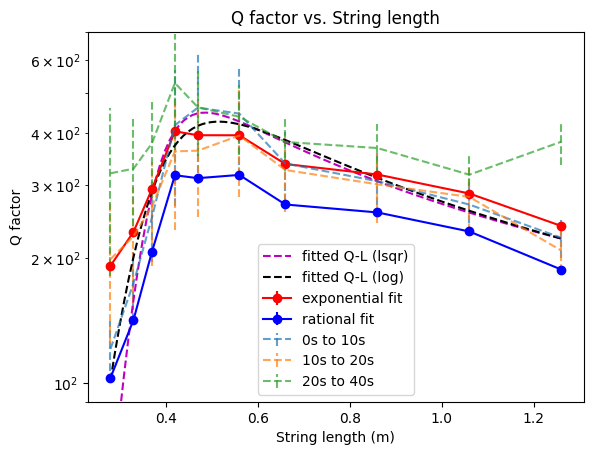

In [37]:
def fit_fun(x, a1, k1, a2, k2):
    return 1.0 / (a1*x**k1 + a2*x**k2)

params_lsqr, popv_lsqr = scipy.optimize.curve_fit(
    fit_fun, ls, qs.T[2],
    p0=(4e-3, 1.0, 1e-4, -3.0), sigma=qes.T[0])
print(params_lsqr, popv_lsqr.diagonal()**0.5)

params_log, popv_log = scipy.optimize.curve_fit(
    lambda x, a1, k1, a2, k2: np.log(fit_fun(x, a1, k1, a2, k2)),
    ls, np.log(qs.T[2]),
    p0=(4e-3, 1.0, 1e-4, -3.0), sigma=qes.T[0])
print(params_log, popv_log.diagonal()**0.5)

xp = np.linspace(ls[0], ls[-1], 100)
yp_lsqr = fit_fun(xp, *params_lsqr)
yp_log = fit_fun(xp, *params_log)

plt.title("Q factor vs. String length")
plt.xlabel("String length (m)")
plt.ylabel("Q factor")
plt.errorbar(ls, qs.T[0], yerr=qes.T[0], fmt="ro-", label="exponential fit")
plt.errorbar(ls, qs.T[1], yerr=qes.T[1], fmt="bo-", label="rational fit")
plt.errorbar(ls, qs.T[2], yerr=qes.T[2], fmt="--", label="0s to 10s", alpha=0.7)[-1][0].set_linestyle('--')
plt.errorbar(ls, qs.T[3], yerr=qes.T[3], fmt="--", label="10s to 20s", alpha=0.7)[-1][0].set_linestyle('--')
plt.errorbar(ls, qs.T[4], yerr=qes.T[4], fmt="--", label="20s to 40s", alpha=0.7)[-1][0].set_linestyle('--')
plt.plot(xp, yp_lsqr, "m--", label="fitted Q-L (lsqr)")
plt.plot(xp, yp_log, "k--", label="fitted Q-L (log)")
plt.yscale("log")
plt.ylim([90, 700])
plt.legend()
plt.show()